<a href="https://colab.research.google.com/github/juantoroa/GRUPO-9-MIAD-ML-NPL/blob/main/Proyecto%20RON-MON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Subir el archivo
uploaded = files.upload()

# Ver qué archivos se subieron
print("Archivos subidos:", list(uploaded.keys()))

# Cargar los datos usando el nombre del archivo subido
# Reemplaza 'PROYECTO (1).xlsx' con el nombre exacto que aparece arriba
df = pd.read_excel('PROYECTO.xlsx', sheet_name='Hoja')

Saving PROYECTO  (1).xlsx to PROYECTO  (1) (1).xlsx
Archivos subidos: ['PROYECTO  (1) (1).xlsx']


=== MODELO SUPERVISADO ===
RON - RMSE: 0.000
RON - R²: 0.999
MON - RMSE: 0.880
MON - R²: 0.989

=== MODELO NO SUPERVISADO ===
Componentes PCA: 4
Varianza explicada: 0.983

Relación Clusters - RON/MON:
              RON                  MON          
             mean       std       mean       std
Cluster                                         
0        0.073136  0.016386  89.920074  2.503602
1        0.066223  0.002910  88.700329  3.362689
2        0.064075  0.001766  63.645349  1.782837


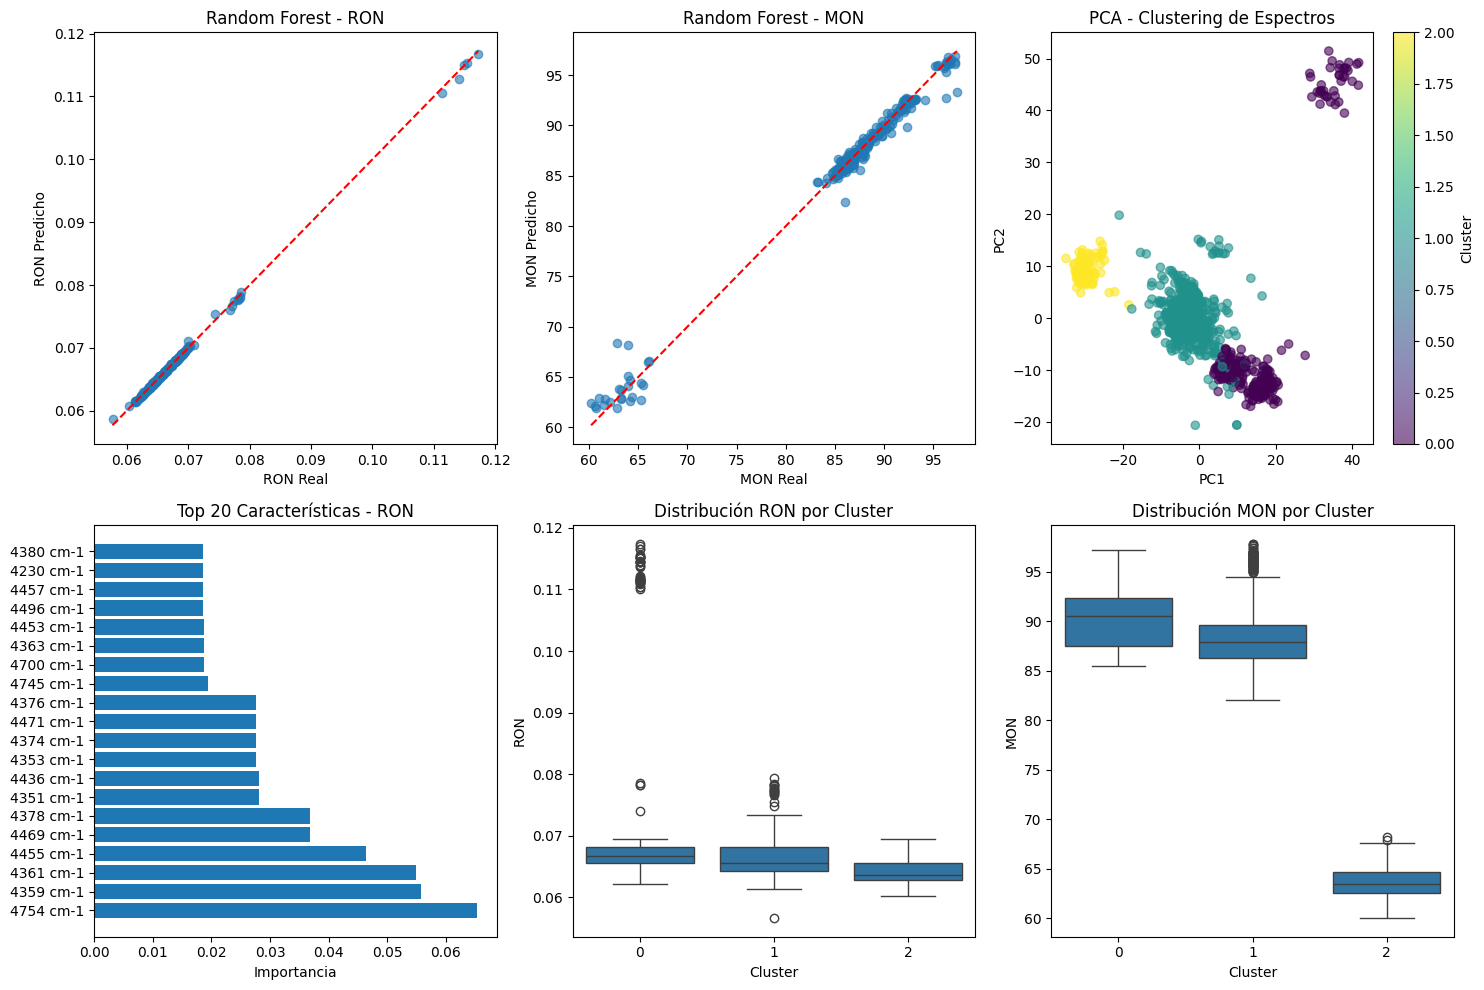

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
# df = pd.read_excel('PROYECTO (1).xlsx', sheet_name='Hoja1 (2)')

# Preprocesamiento
# Extraer características espectrales (columnas 2-429)
X = df.iloc[:, 1:429]  # Espectros
y_ron = df.iloc[:, 429]  # RON
y_mon = df.iloc[:, 430]  # MON

# Dividir datos
X_train, X_test, y_ron_train, y_ron_test, y_mon_train, y_mon_test = train_test_split(
    X, y_ron, y_mon, test_size=0.2, random_state=42
)

# Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODELO SUPERVISADO: Random Forest para RON y MON
print("=== MODELO SUPERVISADO ===")

# Modelo para RON
rf_ron = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ron.fit(X_train_scaled, y_ron_train)

# Modelo para MON
rf_mon = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mon.fit(X_train_scaled, y_mon_train)

# Predicciones
y_ron_pred = rf_ron.predict(X_test_scaled)
y_mon_pred = rf_mon.predict(X_test_scaled)

# Evaluación
print(f"RON - RMSE: {np.sqrt(mean_squared_error(y_ron_test, y_ron_pred)):.3f}")
print(f"RON - R²: {r2_score(y_ron_test, y_ron_pred):.3f}")
print(f"MON - RMSE: {np.sqrt(mean_squared_error(y_mon_test, y_mon_pred)):.3f}")
print(f"MON - R²: {r2_score(y_mon_test, y_mon_pred):.3f}")

# MODELO NO SUPERVISADO: PCA + Clustering
print("\n=== MODELO NO SUPERVISADO ===")

# Aplicar PCA
pca = PCA(n_components=0.95)  # Retener 95% de varianza
X_pca = pca.fit_transform(X_train_scaled)

print(f"Componentes PCA: {pca.n_components_}")
print(f"Varianza explicada: {np.sum(pca.explained_variance_ratio_):.3f}")

# Clustering con K-means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Analizar relación clusters vs RON/MON
df_clusters = pd.DataFrame({
    'Cluster': clusters,
    'RON': y_ron_train.values,
    'MON': y_mon_train.values
})

print("\nRelación Clusters - RON/MON:")
cluster_stats = df_clusters.groupby('Cluster').agg({
    'RON': ['mean', 'std'],
    'MON': ['mean', 'std']
})
print(cluster_stats)

# Visualizaciones
plt.figure(figsize=(15, 10))

# 1. Predicciones vs Valores Reales
plt.subplot(2, 3, 1)
plt.scatter(y_ron_test, y_ron_pred, alpha=0.6)
plt.plot([y_ron_test.min(), y_ron_test.max()], [y_ron_test.min(), y_ron_test.max()], 'r--')
plt.xlabel('RON Real')
plt.ylabel('RON Predicho')
plt.title('Random Forest - RON')

plt.subplot(2, 3, 2)
plt.scatter(y_mon_test, y_mon_pred, alpha=0.6)
plt.plot([y_mon_test.min(), y_mon_test.max()], [y_mon_test.min(), y_mon_test.max()], 'r--')
plt.xlabel('MON Real')
plt.ylabel('MON Predicho')
plt.title('Random Forest - MON')

# 2. PCA - Componentes principales
plt.subplot(2, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Clustering de Espectros')
plt.colorbar(label='Cluster')

# 3. Importancia de características (primeras 20)
plt.subplot(2, 3, 4)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_ron.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importancia')
plt.title('Top 20 Características - RON')

# 4. Distribución de RON por cluster
plt.subplot(2, 3, 5)
sns.boxplot(data=df_clusters, x='Cluster', y='RON')
plt.title('Distribución RON por Cluster')

# 5. Distribución de MON por cluster
plt.subplot(2, 3, 6)
sns.boxplot(data=df_clusters, x='Cluster', y='MON')
plt.title('Distribución MON por Cluster')

plt.tight_layout()
plt.show()

# Función para predecir nuevos espectros
def predict_fuel_quality(new_spectra):
    """
    Predice RON y MON para nuevos espectros
    """
    new_spectra_scaled = scaler.transform(new_spectra)

    ron_pred = rf_ron.predict(new_spectra_scaled)
    mon_pred = rf_mon.predict(new_spectra_scaled)

    # Clustering
    new_pca = pca.transform(new_spectra_scaled)
    cluster_pred = kmeans.predict(new_pca)

    return ron_pred, mon_pred, cluster_pred

# Ejemplo de uso
# new_data = [...]  # Nuevos espectros
# ron, mon, cluster = predict_fuel_quality(new_data)